# Group Analysis - FOOOFed EEG Analysis: Task
    
Applying FOOOF to task based EEG data, and comparing between young and old groups.

Notes:
- average power spectra vs. average FOOOFs
    - there are 10 segments that don't return a value in the single channel version
        - segments, with all-channel or canonical, have systematically different (lower) alpha power

From the 'ALL' group: 
- best performance (for both canonical & FOOOF) is from dropping those segments
- when doing single channel FOOOF, there is a benefit of other alpha features (CF & BW) 

Status:
- FOOOF fits can help select data to analyze
- Gives more features to use to predict behaviour, and can outperform canonical when these features are combined

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload

In [2]:
import warnings
from os.path import join as pjoin
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr

import patsy
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.diagnostic import compare_cox, compare_j

from fooof.synth.gen import gen_aperiodic, gen_power_spectrum
from fooof.plts import plot_spectra

In [6]:
# Import custom code for this analysis
import sys
sys.path.append('../code')

%autoreload 2
from plts import *
from utils import *
from data_mgmt import *
from analysis import *

# Settings

In [4]:
# Set path to load results from
res_path = '/Users/tom/Documents/Research/1-Projects/fooof/2-Data/Results/'

# Set indices to separate groups
from settings import YNG_INDS, OLD_INDS

# Set which group of FOOOF results to load
#folder = 'FOOOF-SinCh'        # FOOOF fit on an average across power spectra 
folder = 'FOOOF-AllCh'         # Average across FOOOF fits, from each channel

# Model settings - which group to run
group = 'ALL' # 'ALL', 'YNG', 'OLD'

# Wether to save out plots or not
save_fig = False

print('Number of yng subjects: ', len(YNG_INDS))
print('Number of old subjects: ', len(OLD_INDS))

Number of yng subjects:  17
Number of old subjects:  14


In [5]:
# Data settings
srate = 512
tmin, tmax = -0.85, 1.1
times = np.arange(tmin, tmax, 1/srate)
seg_times = [(-0.85, -0.35), (0.1, 0.6), (0.5, 1.0)]
n_subjs = 31
dict_structure = {'YNG' : {}, 'OLD' : {}, 'ALL' : {}}

### Check dropped trials

In [6]:
# Load dropped trials & components
dropped_trials = np.load(pjoin(res_path, 'Group', 'dropped_trials.npy'))
dropped_components = np.load(pjoin(res_path, 'Group', 'dropped_components.npy'))

# Check dropped trials for each subject
print('SubNum \t\t # Dropped Trials \t # Dropped Components')
for ind, trials, components in zip(range(n_subjs), dropped_trials, dropped_components):
    temp_trials = trials[trials < 999.]
    temp_comps = components[components < 999.]
#    print(ind, '\t\t', len(temp_trials), '\t\t\t', len(temp_comps))

SubNum 		 # Dropped Trials 	 # Dropped Components


## Group FOOOFing - Trial Averaged Data

Notes:
- 3D data objects have the shape `[n_loads, n_subjs, n_times]`

### Load Data

In [7]:
# Load behavioural data
behav_dat = pd.read_csv(pjoin(res_path, 'Behav', 'neural_aging_data_behaviour.csv'))

In [8]:
# Convert data types
behav_dat['Age'] = behav_dat['Age'].astype('str')
behav_dat['Load'] = behav_dat['Load'].astype('str')

In [9]:
# Calculate average behaviour across loads
avg_behav = behav_dat.groupby('SubjID').mean()

In [10]:
# Load and extract FOOOF data
load_side = 'Contra'
all_offsets, all_exps = load_fooof_task_ap(res_path, load_side, folder)
all_alphas_cf = load_fooof_task_pe(res_path, load_side, 0, folder)
all_alphas =  load_fooof_task_pe(res_path, load_side, 1, folder)
all_alphas_bw = load_fooof_task_pe(res_path, load_side, 2, folder)
all_r2s, all_errs = load_fooof_task_md(res_path, load_side, folder)

In [11]:
# Load canonical alpha analysis
canonical_group = np.load(pjoin(res_path, 'Group', 'canonical_group.npy'))

In [12]:
# Average across analytic alpha measures to get canonical alpha measure
seg_masks = []
for seg in seg_times:
    seg_masks.append(np.logical_and(times >= seg[0], times <= seg[1]))

canalpha = np.zeros_like(all_alphas)
for subi, subj_dat in enumerate(canonical_group):
    for lodi in range(3):
        for segi, mask in enumerate(seg_masks):
            canalpha[lodi, subi, segi] = np.mean(subj_dat[lodi, mask])

In [13]:
# Number of missing FOOOFed alphas
sum(sum(sum(np.isnan(all_alphas))))

0

In [14]:
# Check where the NaN values are
#nans = np.isnan(all_alphas)

# # Drop missing FOOOF values from other measures
# all_alphas[nans] = np.nan
# all_alphas_cf[nans] = np.nan
# all_alphas_bw[nans] = np.nan
# canalpha[nans] = np.nan
# all_exps[nans] = np.nan
# all_offsets[nans] = np.nan

In [15]:
# `[n_loads, n_subjs, n_times]`

# df[(df>=0)&(df<=20)].dropna()

In [16]:
#set(behav_dat.SubjID.values)

In [17]:
# # Drop behavioural data where the EEG data is NaN
# all_inds = YNG_INDS + OLD_INDS
# for load_ind, subj_ind, times_ind in zip(*nan_inds):
#     if times_ind == 0 or times_ind == 2:
#         index = behav_dat[(behav_dat['Load'] == str(load_ind + 1)) & \
#                           (behav_dat['SubjID'] == subj_ind + 1)].index
#         print(load_ind+1, subj_ind, times_ind, '\t', index)
#         behav_dat.loc[index, "d'"] = np.nan

In [18]:
# qq = np.where(np.isnan(np.concatenate([al_dif_yng, al_dif_old])))
# qq[0]

In [19]:
#ww = np.vstack([al_st_yng, al_st_old])
#ww.shape

In [20]:
#nans = np.isnan(all_alphas)

In [21]:
# print(np.mean(all_alphas[nans]))
# print(np.mean(all_alphas[~nans]))

# print(np.mean(all_alphas_cf[nans]))
# print(np.mean(all_alphas_cf[~nans]))

# print(np.mean(all_alphas_bw[nans]))
# print(np.mean(all_alphas_bw[~nans]))

# print(np.mean(canalpha[nans]))
# print(np.mean(canalpha[~nans]))

## Data Management

In [22]:
## Settings

# Make a data dictionary - each with shape [n_conds, n_times]
data_dict = deepcopy(dict_structure)
diff_data_dict = deepcopy(dict_structure)
behav_dict = deepcopy(dict_structure)

# Set the time segments indices to compute the difference measures with
i1, i2 = 2, 0

In [23]:
# Collect the data and labels into lists for checking through
labels = ['offset', 'exponent', 'alpha_cf', 'alpha_pw', 'alpha_bw', 'canalpha']
datas = [all_offsets, all_exps, all_alphas_cf, all_alphas, all_alphas_bw, canalpha]

In [24]:
# Set up data & diff_data dicts
for label, data in zip(labels, datas):
    data_dict['YNG'][label], data_dict['OLD'][label] = reshape_dat(data)
    data_dict['ALL'][label] = np.concatenate([data_dict['YNG'][label], data_dict['OLD'][label]])
    
    diff_data_dict['YNG'][label] = calc_diff(data_dict['YNG'][label], i1, i2)
    diff_data_dict['OLD'][label] = calc_diff(data_dict['OLD'][label], i1, i2)
    diff_data_dict['ALL'][label] = np.concatenate([diff_data_dict['YNG'][label], diff_data_dict['OLD'][label]])

In [25]:
# Set up the behavioural data dict
for label in ["d'", "Load", 'CDA']:
    behav_dict['ALL'][label] = behav_dat[label].values
    behav_dict['YNG'][label] = behav_dat[behav_dat['Age'] == '1'][label].values
    behav_dict['OLD'][label] = behav_dat[behav_dat['Age'] == '2'][label].values

## Data Checking

Check the FOOOF fit measures, checking whether there is a systematic difference between the groups that could explain the differences. 

In [26]:
# Check if the fit metrics vary by group
for label, data in zip(['Error', 'R^2'], [all_errs, all_r2s]):
    print(label)
    m1, m2 = np.nanmean(data[:, YNG_INDS, :]), np.nanmean(data[:, OLD_INDS, :])
    print('\tMeans: \t\t  {:1.4f} \t {:1.4f} \t diff: {:1.4f}'.format(m1, m2, np.abs(m1-m2)))
    print_stat('\tt-test', *ttest_ind(data[:, YNG_INDS, :].flatten(), data[:, OLD_INDS, :].flatten()))

Error
	Means: 		  0.0352 	 0.0312 	 diff: 0.0040
	t-test: 	  2.8401 	 0.0048
R^2
	Means: 		  0.9739 	 0.9597 	 diff: 0.0142
	t-test: 	  4.5553 	 0.0000


In [27]:
# Check the correlation between FOOOF fit error & R^2
print_stat('Err-R^2 Corr', *spearmanr(all_errs.flatten(), all_r2s.flatten()))

Err-R^2 Corr: 	 -0.4041 	 0.0000


In [28]:
# Check if the fit metrics predict other FOOOF measures, in terms of correlations
print('\t\t  Error \t   R^2')
for label, data in zip(labels, datas):
    print_stat(label,
               spearmanr(all_errs.flatten(), data.flatten())[0],
               spearmanr(all_r2s.flatten(), data.flatten())[0])

		  Error 	   R^2
offset: 	  0.0203 	 0.6291
exponent: 	 -0.1285 	 0.6736
alpha_cf: 	  0.2289 	-0.1435
alpha_pw: 	  0.7015 	 0.2130
alpha_bw: 	  0.2487 	 0.2443
canalpha: 	  0.2869 	-0.0448


## Descriptive Data Checks

In [29]:
# Print out mean values per group
print('Average Values for Metric, per Group: \n')
print('\t\t   YNG \t\t  OLD')
for label in labels:
    print_stat(label,
               np.nanmean(diff_data_dict['YNG'][label]),
               np.nanmean(diff_data_dict['OLD'][label]))

Average Values for Metric, per Group: 

		   YNG 		  OLD
offset: 	 -0.0596 	-0.0682
exponent: 	 -0.0363 	-0.0225
alpha_cf: 	  0.0392 	 0.4310
alpha_pw: 	  0.0777 	-0.0023
alpha_bw: 	 -0.1713 	 0.1980
canalpha: 	  0.0000 	-0.0000


In [30]:
# Print out tests for group differences
print('T-Tests for Differences Between Groups (YNG vs OLD), per Metric: \n')
print('\t\t   t-val \t  p-val')
for label in labels:
    print_stat(label, *nan_ttest(diff_data_dict['YNG'][label], diff_data_dict['OLD'][label]))

T-Tests for Differences Between Groups (YNG vs OLD), per Metric: 

		   t-val 	  p-val
offset: 	  0.3708 	 0.7116
exponent: 	 -0.6098 	 0.5435
alpha_cf: 	 -2.4272 	 0.0172
alpha_pw: 	  2.8027 	 0.0062
alpha_bw: 	 -3.6881 	 0.0004
canalpha: 	  2.2754 	 0.0252


In [31]:
# Check correlations of physiology to behaviour, per group
print('Correlation (r-vals) of each metric with behaviour, per Group: \n')
print('\t\t   YNG \t\t  OLD')
for label in labels:
    print_stat(label,
    nan_corr(diff_data_dict['YNG'][label], behav_dict['YNG']["d'"])[0],
    nan_corr(diff_data_dict['OLD'][label], behav_dict['OLD']["d'"])[0])

Correlation (r-vals) of each metric with behaviour, per Group: 

		   YNG 		  OLD
offset: 	  0.2289 	 0.0633
exponent: 	  0.3594 	-0.1184
alpha_cf: 	  0.2007 	-0.0396
alpha_pw: 	 -0.0810 	 0.3357
alpha_bw: 	  0.0991 	-0.0057
canalpha: 	 -0.1787 	 0.2544


## Fit Models to Predict Behaviour

Predict behaviour output from evoked responses of alpha and aperiodic. 

In [32]:
# Set up model definitions
models_defs = {
    'base_model' : 'behav ~ load',
    'cda_model' : 'behav ~ load + cda',
    'canal_model' : 'behav ~ load + al_dif',
    'f_al_model' : 'behav ~ load  + al_dif',
    'f_al_p_model' : 'behav ~ load + al_cf_dif + al_dif + al_bw_dif',
    'f_ap_model' : 'behav ~ load + off_dif + exp_dif',
    'f_ap_p_model' : 'behav ~ load + off_dif + exp_dif + al_dif'
}

In [33]:
# Set up model data
models_data = {
    'base_model' : lambda group : {'behav' : behav_dict[group]["d'"],
                                   'load' : behav_dict[group]['Load']},
    
    'cda_model' : lambda group : {'behav' : behav_dict[group]["d'"],
                                  'load' : behav_dict[group]['Load'],
                                  'cda' : behav_dict[group]['CDA']}, 
    
    'canal_model' : lambda group : {'behav' : behav_dict[group]["d'"],
                                    'load' : behav_dict[group]['Load'],
                                    'al_dif' : diff_data_dict[group]['canalpha']},
    
    'f_al_model' : lambda group : {'behav' : behav_dict[group]["d'"],
                                   'load' : behav_dict[group]['Load'],
                                   'al_dif' : diff_data_dict[group]['alpha_pw']},
    
    'f_al_p_model' : lambda group : {'behav' : behav_dict[group]["d'"],
                                     'load' : behav_dict[group]['Load'],
                                     'al_cf_dif' : diff_data_dict[group]['alpha_cf'],
                                     'al_dif' : diff_data_dict[group]['alpha_pw'],
                                     'al_bw_dif' : diff_data_dict[group]['alpha_bw']},
    
    'f_ap_model' : lambda group :  {'behav' : behav_dict[group]["d'"],
                                    'load' : behav_dict[group]['Load'],
                                    'off_dif' : diff_data_dict[group]['offset'],
                                    'exp_dif' : diff_data_dict[group]['exponent']},
    
    'f_ap_p_model' : lambda group :  {'behav' : behav_dict[group]["d'"],
                                      'load' : behav_dict[group]['Load'],
                                      'al_dif' : diff_data_dict[group]['alpha_pw'],
                                      'off_dif' : diff_data_dict[group]['offset'],
                                      'exp_dif' : diff_data_dict[group]['exponent']}
}

In [34]:
# Fit models, across groups
models_results = deepcopy(dict_structure)
for group in models_results.keys():
    for model_name, model_def in models_defs.items():
        models_results[group][model_name] = run_model(model_def,
                                                      models_data[model_name](group),
                                                      print_model=False)

In [35]:
# Check the model performances - per model def per group
print('\t\t\t  R^2 Adj \t  p-val')
for group_label, group_models in models_results.items():
    print(group_label)
    for model_label, model_results in group_models.items():
        print_stat('\t' + model_label, model_results.rsquared_adj, model_results.f_pvalue)

			  R^2 Adj 	  p-val
YNG
	base_model: 	  0.0471 	 0.1181
	cda_model: 	  0.0609 	 0.1153
	canal_model: 	  0.0692 	 0.0960
	f_al_model: 	  0.0363 	 0.1957
	f_al_p_model: 	  0.0139 	 0.3531
	f_ap_model: 	  0.1953 	 0.0069
	f_ap_p_model: 	  0.1866 	 0.0128
OLD
	base_model: 	  0.1867 	 0.0067
	cda_model: 	  0.2324 	 0.0044
	canal_model: 	  0.2341 	 0.0043
	f_al_model: 	  0.2967 	 0.0009
	f_al_p_model: 	  0.2653 	 0.0058
	f_ap_model: 	  0.3479 	 0.0005
	f_ap_p_model: 	  0.3914 	 0.0003
ALL
	base_model: 	  0.1109 	 0.0019
	cda_model: 	  0.1009 	 0.0059
	canal_model: 	  0.1029 	 0.0054
	f_al_model: 	  0.1105 	 0.0038
	f_al_p_model: 	  0.1241 	 0.0052
	f_ap_model: 	  0.1050 	 0.0079
	f_ap_p_model: 	  0.1076 	 0.0103


In [36]:
# Check a particular model
group = 'OLD'
model = 'f_ap_model'
print(models_results[group][model].summary())

                            OLS Regression Results                            
Dep. Variable:                  behav   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     6.469
Date:                Mon, 11 Mar 2019   Prob (F-statistic):           0.000473
Time:                        13:45:13   Log-Likelihood:                -48.704
No. Observations:                  42   AIC:                             107.4
Df Residuals:                      37   BIC:                             116.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9575      0.247     16.015      0.0

### Predicting from FOOOF model with Alpha & Aperiodic

## Model Comparisons

Explicitly test for differences between different model fits. 

#### Comparing Nested Models

Statsmodels offers three tests for nested models: f test, lagrange multiplier, likelihood ratio

Note that these three can be called from a results object, as `compare_x_test` with `f`, `lm` and `lr` as `x`. 

F-test can also be run with `anova_lm`. 

#### Comparing Non-Nested Models

Statmodels offers two tests for non-nested model: cox test & j test

They are better described in the R implementations:

- cox_test: http://math.furman.edu/~dcs/courses/math47/R/library/lmtest/html/coxtest.html
- j_test: http://math.furman.edu/~dcs/courses/math47/R/library/lmtest/html/jtest.html

In [37]:
# Set group to compare
group = 'OLD'

In [38]:
# Check the model names
print('\n'.join(models_results[group].keys()))

base_model
cda_model
canal_model
f_al_model
f_al_p_model
f_ap_model
f_ap_p_model


In [39]:
# Compare nested models: alpha models vs base models
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('Canonical alpha vs. Base Model')
    print(anova_lm(models_results[group]['base_model'], models_results[group]['canal_model']))
    print('\n')
    print('FOOOFed alpha vs. Base Model')
    print(anova_lm(models_results[group]['base_model'], models_results[group]['f_al_model']))
    print('\n')
    print('FOOOF aperiodic vs. Base Model')
    print(anova_lm(models_results[group]['base_model'], models_results[group]['f_ap_model']))

Canonical alpha vs. Base Model
   df_resid        ssr  df_diff   ss_diff         F   Pr(>F)
0      39.0  32.872153      0.0       NaN       NaN      NaN
1      38.0  30.163025      1.0  2.709128  3.413015  0.07248


FOOOFed alpha vs. Base Model
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      39.0  32.872153      0.0       NaN       NaN       NaN
1      38.0  27.695481      1.0  5.176672  7.102731  0.011236


FOOOF aperiodic vs. Base Model
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0      39.0  32.872153      0.0       NaN       NaN       NaN
1      37.0  25.004128      2.0  7.868025  5.821377  0.006337


In [40]:
# Compare different alpha models
print('Canonical alpha vs. FOOOFed Alpha')
print_stat('Alpha-Model Compare', *compare_cox.run(models_results[group]['canal_model'],
                                                   models_results[group]['f_al_model']))

Canonical alpha vs. FOOOFed Alpha
Alpha-Model Compare: 	 -2.9150 	 0.0036


In [41]:
# Compare if the + models are any better
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('FOOOF Alpha + + vs. FOOOF Alpha')
    print(anova_lm(models_results[group]['f_al_model'], models_results[group]['f_al_p_model']))
    print('\n')
    print('FOOOF AP + vs. FOOOF AP')
    print(anova_lm(models_results[group]['f_ap_model'], models_results[group]['f_ap_p_model']))

FOOOF Alpha + + vs. FOOOF Alpha
   df_resid        ssr  df_diff  ss_diff         F    Pr(>F)
0      38.0  27.695481      0.0      NaN       NaN       NaN
1      36.0  27.409831      2.0  0.28565  0.187586  0.829763


FOOOF AP + vs. FOOOF AP
   df_resid        ssr  df_diff   ss_diff        F    Pr(>F)
0      37.0  25.004128      0.0       NaN      NaN       NaN
1      36.0  22.705774      1.0  2.298354  3.64404  0.064267


## Plot the difference of FOOOFs 

Make FOOOF plots of the average difference

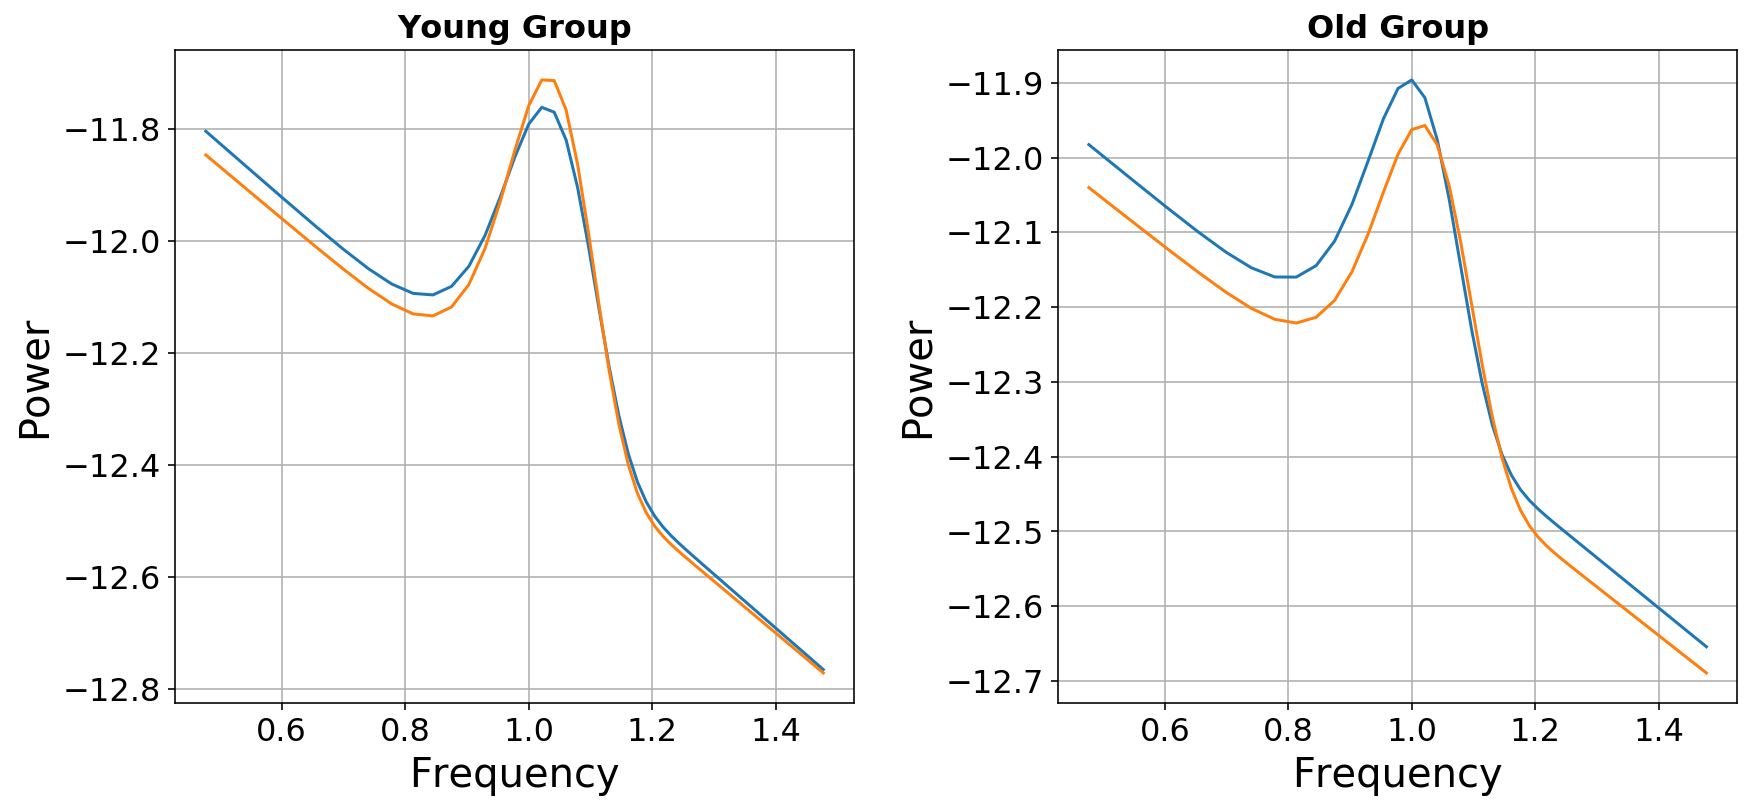

In [42]:
_, ax = plt.subplots(1, 2, figsize=(14, 6))
titles = ['Young Group', 'Old Group']
for ii, inds in enumerate([YNG_INDS, OLD_INDS]):

    time_exps = all_exps[:, inds, :].mean(0).mean(0)
    time_offs = all_offsets[:, inds, :].mean(0).mean(0)
    time_al_cf = all_alphas_cf[:, inds, :].mean(0).mean(0)
    time_al_pw = all_alphas[:, inds, :].mean(0).mean(0)
    time_al_bw = all_alphas_bw[:, inds, :].mean(0).mean(0)

    fs, base_spectrum = gen_power_spectrum([3, 30],
                                           [time_offs[0], time_exps[0]],
                                           [time_al_cf[0], time_al_pw[0], time_al_bw[0]/2], nlv=0)
    fs, task_spectrum = gen_power_spectrum([3, 30],
                                           [time_offs[2], time_exps[2]],
                                           [time_al_cf[2], time_al_pw[2], time_al_bw[2]/2], nlv=0)

    plot_spectra(fs, [base_spectrum, task_spectrum], True, True, ax=ax[ii])
    ax[ii].set_title(titles[ii], {'fontsize' : 16, 'fontweight' : 'bold'})
    
plt.subplots_adjust(wspace=0.3)

## Correlations

Check the correlational structure between canonical and FOOOF features. 

### Correlations between Physioligical features

In [59]:
# Settings
group = 'OLD'
cur_dat = data_dict
#cur_dat = diff_data_dict

# Calculate correlations
corrs = np.zeros(shape=[len(datas), len(datas)])
for i1, label1 in enumerate(labels):
    for i2, label2 in enumerate(labels):
        corr = nan_corr(cur_dat[group][label1].flatten(),
                        cur_dat[group][label2].flatten())
        corrs[i1, i2] = corr[0]
        #print_stat(label1 + '_' + label2, *corr)

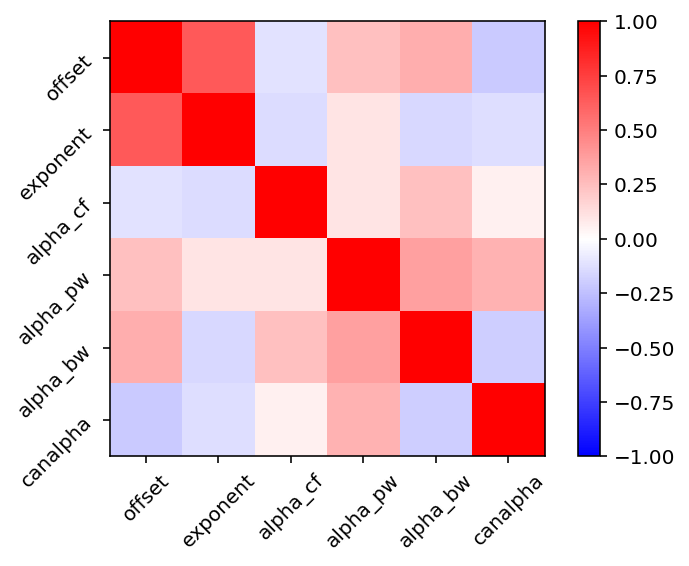

In [60]:
# Plot the correlation matrix
plt.imshow(corrs, cmap='bwr', vmin=-1, vmax=1)
plt.gca().set_xticklabels([''] + labels, rotation=45);
plt.gca().set_yticklabels([''] + labels, rotation=45);
plt.colorbar();

### Relation Between FOOOF & Canonical

In [81]:
# Generate the power @ alpha frequency given the aperiodic component, from the FOOOF fits
ap_alpha = []
for cf, off, exp in zip(all_alphas_cf.flatten(), all_offsets.flatten(), all_exps.flatten()):
    ap_alpha.append(gen_aperiodic(np.array([10]), [off, exp])[0])
ap_alpha = np.array(ap_alpha)

# Calculate the total power at 10 Hz (or about) from the 
foo_total = ap_alpha + all_alphas.flatten()

# Find NaN locations
nan_inds = np.isnan(ap_alpha)

In [82]:
# Calculate correlation between canonical and FOOOF alpha
print_stat('CanalvsFAlpha', *nan_corr(np.array(all_alphas.flatten()), np.array(canalpha.flatten())))

CanalvsFAlpha: 	  0.3172 	 0.0000


In [83]:
# Calculate correlation between canonical alpha and aperiodic component @ 10 Hz
print_stat('Canalvs10HzAP', *nan_corr(np.array(ap_alpha), np.array(canalpha.flatten())))

Canalvs10HzAP: 	  0.0258 	 0.6678


In [84]:
# Calculate correlation between the canonical alpha and the FOOOF model total @ 10 Hz
print_stat('CanalvsTotalFOOOF', *nan_corr(np.array(foo_total.flatten()), np.array(canalpha.flatten())))

CanalvsTotalFOOOF: 	  0.2279 	 0.0001


# Predict canonalpha from FOOOF alpha & exponent

1) Canonical Alpha vs. FOOOF Alpha

2) Canonical Alpha vs. Exponent

3) Canonical Alpha cs. FOOOF Alpha + Exponent

In [93]:
from sklearn import preprocessing

In [94]:
can_scaled = preprocessing.scale(canalpha.flatten())
alf_scaled = preprocessing.scale(all_alphas.flatten())
exp_scaled = preprocessing.scale(all_exps.flatten())

(-1e-06, 1e-06)

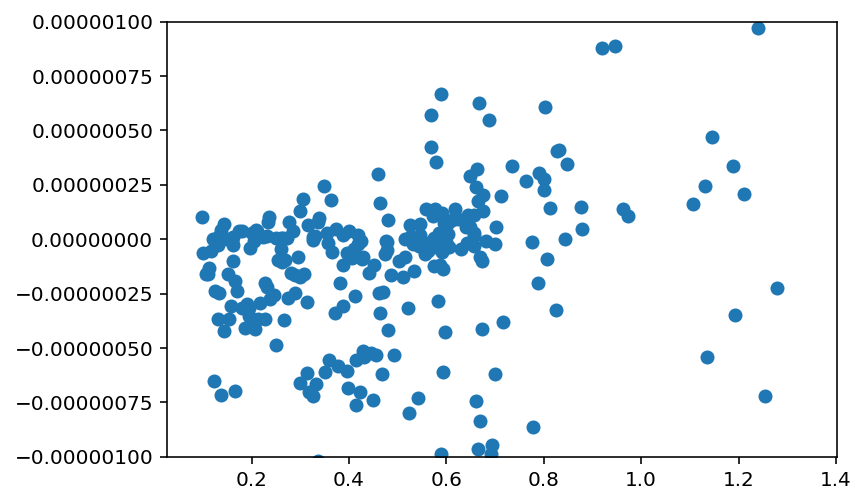

In [95]:
plt.scatter(all_alphas.flatten(), canalpha.flatten())
plt.ylim([-0.0000010, 0.0000010])

In [96]:
print(pearsonr(all_alphas.flatten(), canalpha.flatten()))

(0.3171585568066734, 6.15531793665704e-08)


(0.3171585568066735, 6.155317936656822e-08)


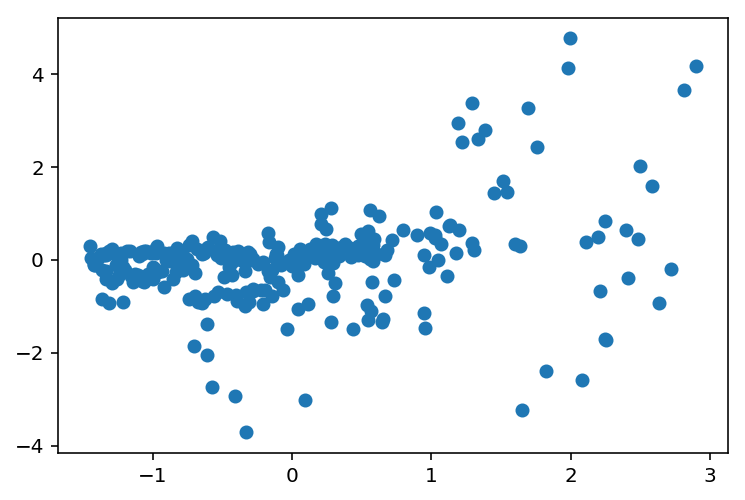

In [97]:
print(pearsonr(alf_scaled, can_scaled))
plt.scatter(alf_scaled, can_scaled)

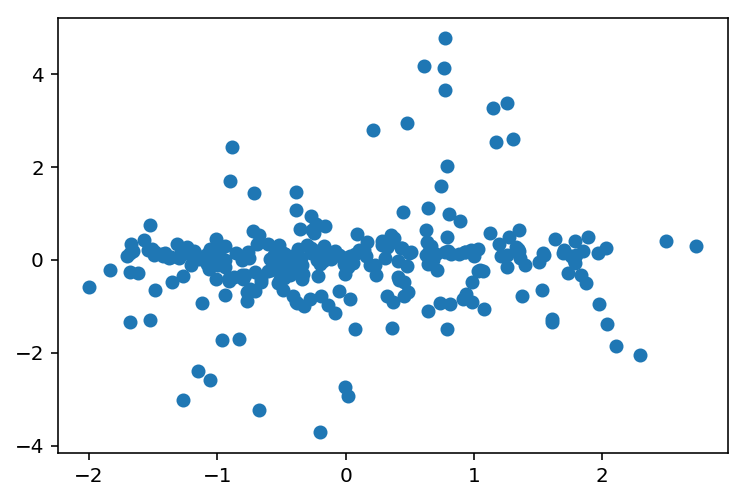

In [98]:
plt.scatter(exp_scaled, can_scaled)

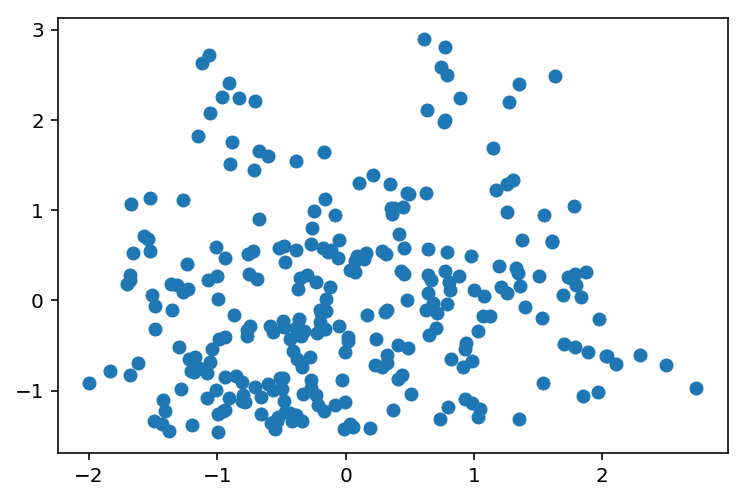

In [99]:
plt.scatter(exp_scaled, alf_scaled)

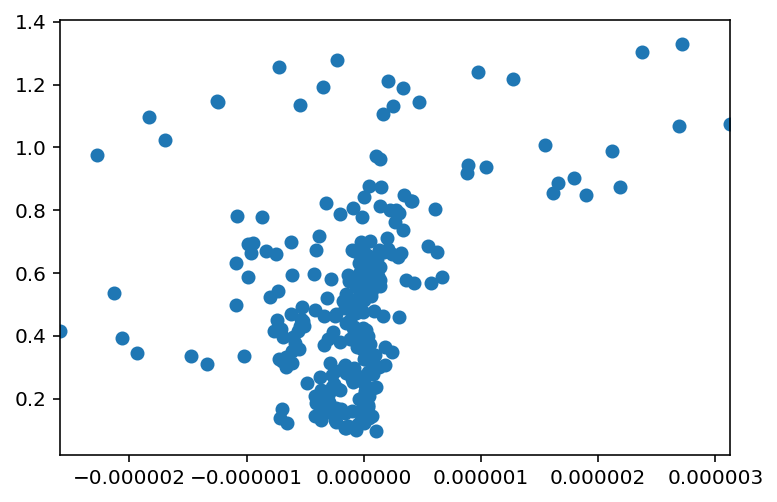

In [100]:
plt.scatter(canalpha.flatten(), all_alphas.flatten())
plt.xlim([canalpha.flatten().min(), canalpha.flatten().max()]);

In [105]:
data = pd.DataFrame()

group = 'YNG'

data['exp'] = diff_data_dict[group]['exponent']
data['off'] = diff_data_dict[group]['offset']
data['fal'] = diff_data_dict[group]['alpha_pw']
data['canal'] = diff_data_dict[group]['canalpha']

qq = run_model("canal ~ exp * off", data, True)

                            OLS Regression Results                            
Dep. Variable:                  canal   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     15.25
Date:                Mon, 11 Mar 2019   Prob (F-statistic):           4.59e-07
Time:                        13:58:54   Log-Likelihood:                 656.66
No. Observations:                  51   AIC:                            -1305.
Df Residuals:                      47   BIC:                            -1298.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.544e-07    1.2e-07      2.126      0.0

In [56]:
# # Build the dataframe
# df = pd.DataFrame()

# df['exp'] = np.concatenate([exp_dif_yng, exp_dif_old])
# df['fal'] = np.concatenate([al_dif_yng, al_dif_old])
# df['canal'] = np.concatenate([canal_dif_yng, canal_dif_old])
# #df['exp'] = all_exps[:, :, 1].flatten()
# #df['fal'] = all_alphas[:, :, 1].flatten()
# #df['canal'] = canalpha[:, :, 1].flatten()

# outcome, predictors = patsy.dmatrices("canal ~ fal * exp", df)
# mod = sm.OLS(outcome, predictors)
# res = mod.fit()

# # Check out the results
# print(res.summary())

In [57]:
# # Get the original values and predictions of alpha
# canal_vals = df['canal'].values[~np.isnan(df['canal'])]
# canalpha_predictions = res.predict(predictors)

In [58]:
# # Check the correlation between measured values and predictions
# plt.scatter(canalpha_predictions, canal_vals)
# plt.xlim([outcome.min(), outcome.max()]);
# plt.ylim([outcome.min(), outcome.max()]);
# nan_corr(canal_vals, canalpha_predictions)